# **Twitter Sentiment Classifier** 👍👎
*using* **Feed-Forward Neural Networks** *and the* **GloVe** model.

Let's import some essential libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import torch
import torch.nn as nn
import torch.optim as optim
from nltk.corpus import stopwords
import string
import re
from textblob import TextBlob

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## **Load the dataset** 🗂

We have to mount (connect) Google Drive where I keep the dataset.

Then, we can import the data in csv format using the pandas `read_csv` method.  
I load 0.65M out of ~1M data from the SentimentTweets.csv dataset because more data lead to memory crashes on google colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_PATH = '/content/drive/My Drive/SentimentTweets.csv'
data_csv = pd.read_csv(DATA_PATH, nrows=650000)
data_csv = data_csv.dropna()
data_csv.head()

Mounted at /content/drive


,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


## **Data pre-processing** 💽

Converting the csv file data into Pandas DataFrame data structure.

In [ ]:
# Convert the data (from csv type) into dataframe data structure
df = pd.DataFrame(data=data_csv) 
df.head(10)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...
5,725609,0,2262367427,Sat Jun 20 22:22:34 PDT 2009,NO_QUERY,farmtrain,Woot truck fixed!!! Now workin http://myloc.m...
6,1361765,4,2049183514,Fri Jun 05 16:26:26 PDT 2009,NO_QUERY,tinadallasfla,@BLAQSHEEPCEO yea I melt at that lol
7,114606,0,1826379900,Sun May 17 08:22:16 PDT 2009,NO_QUERY,Isoebelle,wants to do something radical...but not sure w...
8,620064,0,2228196366,Thu Jun 18 14:08:18 PDT 2009,NO_QUERY,alox,"@brlamb scratch that, @bgilgoff tweeted it. Ch..."
9,564150,0,2206118765,Wed Jun 17 06:02:05 PDT 2009,NO_QUERY,asimpleparadox,I am sore everywhere. Also found out an assess...


As we can see from above, the target column has 0s and 4s denoting the negative and the positive class respectively. We are going to change the *4s into 1s* using the `replace` method and hence we have:

0 $\rightarrow$ negative tweet 👎

1 $\rightarrow$ positive tweet 👍

In [ ]:
df['target'] = df['target'].replace(4,1)
df.head(10)

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,1,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,1,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,1,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...
5,725609,0,2262367427,Sat Jun 20 22:22:34 PDT 2009,NO_QUERY,farmtrain,Woot truck fixed!!! Now workin http://myloc.m...
6,1361765,1,2049183514,Fri Jun 05 16:26:26 PDT 2009,NO_QUERY,tinadallasfla,@BLAQSHEEPCEO yea I melt at that lol
7,114606,0,1826379900,Sun May 17 08:22:16 PDT 2009,NO_QUERY,Isoebelle,wants to do something radical...but not sure w...
8,620064,0,2228196366,Thu Jun 18 14:08:18 PDT 2009,NO_QUERY,alox,"@brlamb scratch that, @bgilgoff tweeted it. Ch..."
9,564150,0,2206118765,Wed Jun 17 06:02:05 PDT 2009,NO_QUERY,asimpleparadox,I am sore everywhere. Also found out an assess...


### **Data cleaning** 🧹

In the following code snippet we "clean" the data by doing the following:

We are going to classify tweets. As we all know, twitter users use the symbols # and @ a lot. This may cause problem to the classifier, thus we are going to remove them, using TextBlob. We are also going to lemmatize the data in order to avoid multiple representations of the same word
* **Drop the uneseccary columns** such as "Unnamed: 0", "id", etc
* **Lower** the characers using the string method `lower` 
* **Remove special characters** such as punctuation points, links, weird characters, etc.

In [ ]:
# Drop the unescessary columns
df.drop(columns = ['Unnamed: 0', 'id', 'date', 'flag', 'user'], inplace = True)
df.head()

,target,text
0,0,#brokenpromises...
1,0,David Carradine so sad. Thai's law not sure i...
2,1,A @ 415 B @ 425. Tell your bro i say congrats!
3,1,@littlefluffycat Indeed.
4,1,Completed Race 4 Life in 58mins with girlies f...


In [ ]:
# Define the function for text cleaning
def text_cleaning(text):
  # Lower characters
  text = text.lower()
  # Remove links
  text = re.sub('http://\S+|https://\S+', '', text)
  # Remove non alphanumeric characters
  text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
  # Remove punctuation
  text = text.translate(str.maketrans('', '', string.punctuation))
  # Remove stopwords
  #StopWords = stopwords.words("english")
  #text = ' '.join([word for word in text.split() if word not in StopWords])
  return text

df['text']=df['text'].apply(text_cleaning)
df.head(10)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,completed race 4 life in 58mins with girlies f...
5,0,woot truck fixed now workin http myloc me 4nif
6,1,blaqsheepceo yea i melt at that lol
7,0,wants to do something radical but not sure wha...
8,0,brlamb scratch that bgilgoff tweeted it chann...
9,0,i am sore everywhere also found out an assessm...


### **Tokenization and Lemmatization** 🔑

**Tokenization** is necessary to prepare the data in order to vectorize them using the GloVe pre-trained word embeddings.  
The goal of **Lemmatization** (or Stemming) is to reduce inflectional forms and sometimes derivationally related forms of a word to a common base form.  
For instance, Lemmatization (or Stemming) will do the following:   
am, are, is $\Rightarrow$ be  
car, cars, car's, cars' $\Rightarrow$ car

In [ ]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

# Function that lemmatizes the tokenized text
# text is being tokenized and passed immidiately into the lemmatizer 
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w, pos="v") for w in w_tokenizer.tokenize(text)])

df['text'] = df.text.apply(lemmatize_text).copy()

df.head(10)

,target,text
0,0,brokenpromises
1,0,david carradine so sad thai s law not sure if ...
2,1,a 415 b 425 tell your bro i say congrats
3,1,littlefluffycat indeed
4,1,complete race 4 life in 58mins with girlies fr...
5,0,woot truck fix now workin http myloc me 4nif
6,1,blaqsheepceo yea i melt at that lol
7,0,want to do something radical but not sure what...
8,0,brlamb scratch that bgilgoff tweet it channel ...
9,0,i be sore everywhere also find out an assessme...


### **Split the dataset** 🖇
into *training, validation* and *testing* sets.

In [ ]:
from sklearn.model_selection import train_test_split

X = pd.DataFrame(df, columns = ['text'])
Y = pd.DataFrame(df, columns = ['target'])

# Using the train_test_split method 
# we get from X -> trainX, testX and from Y -> trainY, testY
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.05, random_state=123)
trainX, valX, trainY, valY = train_test_split(trainX, trainY, test_size=0.05, random_state=123)

In [ ]:
print(trainX.head())

                                                     text
252794  and they be back within hear distance with win...
591124  3 majorettes show tomorrow fuck me i m gonna b...
4804                      choebe guess what i m dling now
230626  i break my hello kitty mobile charm it be one ...
81794   just get do watch some buffy hurray it s bryan...


## **Vectorization with the GloVe pre-trained word embeddings** 🔢

Now, we need to ***convert the text into numbers using the GloVe model.*** 

We will use the pre-trained **_glove.twitter.27B.25d.txt_** file which provides *27 billion tokens* extracted from tweets and vectorized using the GloVe model in *25 dimensions*. The .zip file from [GloVe](https://nlp.stanford.edu/projects/glove/) also contains encodings in 50, 100 and 200 dimensions. For the sake of speed I chose to use the 25-dimensions file.

### **Download the GloVe pre-trained word embeddings ⬇️**
First of all we download the `glove.twitter.27B.zip` archive which contains the GloVe word embeddings.

In [ ]:
!wget -nc https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip -n -q glove.twitter.27B.zip

--2021-09-18 08:12:57--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2021-09-18 08:12:58--  http://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove.twitter.27B.zip’

glove.twitter.27B.z 100%[===================>]   1.42G  5.29MB/s    in 4m 51s  

2021-09-18 08:17:49 (4.98 MB/s) - ‘glove.twitter.27B.zip’ saved [1520408563/1520408563]



### **Build the GloVe vocabulary 📖** 

The `glove.twitter.27B.25d.txt` file has the following format: Each word is followed by 25 coefficients that define that specific word. We want to build a vocabulary of these words that map each one of them to their corresponding 25-dimensional vector that defines them. So, we go through the file and split each line to get the word and the 25 coefficients that are associated with it. The following code does that.

In [ ]:
import os
GloVe_path = '/content/glove.twitter.27B.25d.txt'
GloVe_vocab = {}
with open(GloVe_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        GloVe_vocab[word] = coefs

print("Found %s word vectors on the GloVe file." % len(GloVe_vocab))

Found 1193514 word vectors on the GloVe file.


In [ ]:
# Let's play a bit with the GloVe word embeddings :)

# This is the representation of the word "hello"
# using the GloVe 25 dimensional encodings
print(f'"hello" -> {GloVe_vocab["hello"]}')

# You can also see that this is a 25-dimensional vector
print(f'Shape: {GloVe_vocab["hello"].shape}')

# We can also see that some words are not presented in the GloVe vocabulary
# Let's test for the word "asdfghjkldfgdfgdfgd"
# if you run the command below will get KeyError because there is no such key
# in the dictionary
# print(f'"asdfghjkldfgdfgdfgd" -> {GloVe_vocab["asdfghjkldfgdfgdfgd"]}')

"hello" -> [-0.77069    0.12827    0.33137    0.0050893 -0.47605   -0.50116
  1.858      1.0624    -0.56511    0.13328   -0.41918   -0.14195
 -2.8555    -0.57131   -0.13418   -0.44922    0.48591   -0.6479
 -0.84238    0.61669   -0.19824   -0.57967   -0.65885    0.43928
 -0.50473  ]
Shape: (25,)


### **Word Vectors into Tweet Vectors ➡️**

Now that we have the vocabulary with all the words from the GloVe model, we have to represent each tweet in the dataset with the word vectors for each word in the tweet. In other words, each tweet in the dataset has to be represented with numbers in order to be inputed into our Neural Network model.

But, if each tweet consists of [tweet_len] words and each word as we know is represented by a 25-dimensional vector, then we will have a `[tweet_len] x [25]` matrix for each tweet. 

But how this `[tweet_len] x [25]` embeddings matrix will be passed as a single feature into a neuron of our model?   
⇒ We have to represent the *whole* tweet (that consists of many words) with a *single* embedding vector. 

We are going to use a very simple, yet surprisingly effective technique:
  
```
We are getting the mean vector of the vectors for each word presented in the tweet. 
This will be our representative 25 dimensional vector for the tweet.
```

So we are going to do the following:
  1. Iterate through dataset and for each tweet,
  2. Split the tweet into its tokens and,
  3. For each token in the tweet get its word vector by the GloVe vocabulary we have built
  4. Then for all the words in the tweet calculate the mean of their word vectors
  5. This (mean) vector will be the representation of the whole tweet.

Then, in total we will have `[dataset_size] x [25]` for representing the whole dataset's tweets.

Another concern, now about representing each word we find in each tweet in the datset...

How can we handle the words that are *not* encoded by the GloVe model (not presented in our GloVe vocabulary)?  
=>  We just fill their word vector with zeros (we kinda ignore them 😁)  
So, the idea is simple:

```
If a word from the dataset is also present in the GloVe vocabulary then 
  this word is represented by the 25-dimensional GloVe vector containing the 25 coefficients that represent this word
else (this word is not present in the GloVe vocabulary)
  this word is represented by a 25-diemensional vector filled with zeros
```

The following function, given a dataset returns the NumPy **tweet vector** with the associated numbers for each tweet, and, how many _words_found_ and also the _matrix_len_. 

In [ ]:
def GloVe_TweetVectors(dataset):
  matrix_len = dataset['text'].str.split().str.len().sum()
  words = 0
  words_found = 0
  tweet_vectors = []

  for i, row in enumerate(dataset['text']):
    splitted_words = str(row).split(' ')
    word_coeffs = np.zeros((len(splitted_words), 25))
    for j, word in enumerate(splitted_words):
      words += 1
      if word in GloVe_vocab:
        word_coeffs[j] = GloVe_vocab[word]
        words_found += 1
    # get the mean of all the words in each tweet 
    tweet_vector = np.mean(word_coeffs, axis=0)
    tweet_vectors.append(tweet_vector)
  return np.array(tweet_vectors), words_found, matrix_len

Let's see how looks the tweet vector of the first tweet in the `trainX` dataset.

In [ ]:
# Get the 1st tweet from train_X
tweet1 = trainX.iloc[0] # iloc[0] is equivalent to trainX[0] for pd DataFrame
# Get the text from tweet1 because now is in form "text tweet1"
tweet1 = tweet1.iloc[0] 
print(tweet1)
print(f'Length of the tweet: {len(tweet1)}')

# Get it as a pd.DataFrame in order to pass it to our method below 
# which gets as input a dataset (pd.Dataframe)
tweet1_df = trainX[:1]

tweet1vector, _, _ = GloVe_TweetVectors(pd.DataFrame(tweet1_df))
print(f'Tweet vector shape: {tweet1vector.shape}')

and they be back within hear distance with windows close and headphones on
Length of the tweet: 74
Tweet vector shape: (1, 25)


Let's see how many of the words from our dataset are presented by the GloVe word embeddings.🤔

We get a ratio of 94% which is acceptable for our model.

In [ ]:
glove_trainX, words_found, matrix_len = GloVe_TweetVectors(pd.DataFrame(trainX))
print(f'Train dataset shape: {glove_trainX.shape}')
print('Training Set match with GloVe embeddings (ratio): ', round(words_found/matrix_len, 2))

glove_valX, words_found, matrix_len = GloVe_TweetVectors(pd.DataFrame(valX))
print('Validation Set match with GloVe embeddings (ratio):', round(words_found/matrix_len,2))

glove_testX, words_found, matrix_len = GloVe_TweetVectors(pd.DataFrame(testX))
print('Test Set match with GloVe embeddings (ratio): ', round(words_found/matrix_len,2))


Train dataset shape: (586625, 25)
Training Set match with GloVe embeddings (ratio):  0.94
Validation Set match with GloVe embeddings (ratio): 0.94
Test Set match with GloVe embeddings (ratio):  0.94


In [ ]:
# Convert X datasets to tensors with function convert_to_tensor.
glove_trainX = torch.tensor(glove_trainX)
glove_valX = torch.tensor(glove_valX)
glove_testX = torch.tensor(glove_testX)

In [ ]:
# Convert Y labels to tensors with torch.squeeze.
trainY = torch.squeeze(torch.from_numpy(trainY.to_numpy()).float())
valY = torch.squeeze(torch.from_numpy(valY.to_numpy()).float())
testY = torch.squeeze(torch.from_numpy(testY.to_numpy()).float())

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)

Device available for running: 
cuda


## **Feed-Forward Neural Network** 🧠

I chose a structure of *three hidden layers*, hence *four functions* in total with each one having the ReLU activation function, plus the sigmoid activation function at the output.

The *structure* of the network is as follows:

Input $\rightarrow$  
  Linear Layer $\rightarrow$ ReLU  
  Linear Layer $\rightarrow$ ReLU   
  Linear Layer $\rightarrow$ ReLU  
  Linear Layer $\rightarrow$ Sigmoid  
$\rightarrow$ Output

### **Building the network** 🔨

In [ ]:
class FeedForwardNeuralNetwork(nn.Module):
  def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, output_dim):
    super(FeedForwardNeuralNetwork, self).__init__()

    self.f_1 = nn.Linear(input_dim, hidden_dim_1)
    self.relu_1 = nn.ReLU()

    self.f_2 = nn.Linear(hidden_dim_1, hidden_dim_2)
    self.relu_2 = nn.ReLU()

    self.f_3 = nn.Linear(hidden_dim_2, hidden_dim_3)
    self.relu_3 = nn.ReLU()

    self.f_4 = nn.Linear(hidden_dim_3, output_dim)

    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.f_1(x)
    out = self.relu_1(out)
    out = self.f_2(out)
    out = self.relu_2(out)
    out = self.f_3(out)
    out = self.relu_3(out)
    out = self.f_4(out)
    out = self.sigmoid(out)
    return out

# Initializing the model's parameters
# you can see that the input dimension is 25, as the GloVe embeddings dimension
input_dim = glove_trainX.shape[1]
#print(f'Input dimension: {input_dim}')
hidden_dim_1 = 1024
hidden_dim_2 = 512
hidden_dim_3 = 256

output_dim = 1

n_epochs = 70

# Define the model in the nn_model variable
nn_model = FeedForwardNeuralNetwork(input_dim, hidden_dim_1, hidden_dim_2, hidden_dim_3, output_dim)
loss_function = nn.BCELoss() # the loss function: Binary Cross Entropy Loss
optimizer = optim.Adam(nn_model.parameters(), lr=1e-4, weight_decay=1e-3)

# Send the computation to the selected device (cpu/gpu)
nn_model.to(device)
loss_function.to(device)

BCELoss()

In [ ]:
import torch
batch_size = 32768 # 2^15

trainX_batches = torch.split(glove_trainX, batch_size)
trainY_batches = torch.split(trainY, batch_size)

In [ ]:
def calculate_accuracy(y_prediction, y_true):
  y_prediction = torch.round(y_prediction)
  correct = (y_true == y_prediction).float() # is it correct? i.e. loss == 0?
  accuracy = correct.sum() / len(correct)
  return accuracy

In [ ]:
plt.style.use('seaborn-whitegrid') # plot style

def plot_loss_accuracy(train_loss, train_acc, val_loss, val_acc, epochs):
  fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,6))

  ax1.plot(range(epochs), train_loss, 'bo-' , label = 'Training loss')
  ax1.plot(range(epochs), val_loss , 'ro-', label = 'Validation loss')
  ax1.set_ylabel('Loss')
  ax1.set_xlabel('Epoch')
  ax1.set_title('Loss/Epoch', y = 1.03, fontsize = 15)
  ax1.set_xlim([-1,epochs])
  ax1.legend(loc="best")

  ax2.plot(range(epochs), train_acc, 'bo-' , label = 'Training accuracy')
  ax2.plot(range(epochs), val_acc , 'ro-', label = 'Validation accuracy')
  ax2.set_ylabel('Accuracy')
  ax2.set_xlabel('Epoch')
  ax2.set_title('Accuracy/Epoch', y = 1.03, fontsize = 15)
  ax2.set_xlim([-1,epochs])
  ax2.legend(loc="best")

  plt.show()

### **Training** 🏋️‍♂️

In [ ]:
train_losses, train_accuracies, val_losses, val_accuracies = [], [], [], []

for epoch in range(n_epochs):
  epoch_loss = epoch_accuracy = 0
  val_loss = val_accuracy = 0

  for trainX_mini_batch, trainY_mini_batch in zip(trainX_batches, trainY_batches):
    trainX_mini_batch = trainX_mini_batch.to(device)
    trainY_mini_batch = trainY_mini_batch.to(device)
    #print(f'trainX_mini_batch shape: {trainX_mini_batch.shape}') # batch_size OK
    #print(f'trainY_mini_batch shape: {trainX_mini_batch.shape}') # batch_size OK
    # Forward pass to get prediction
    train_prediction = nn_model.forward(trainX_mini_batch.float())
    # now squeeze it because it is of size (batch_size, 1) so get rid of 1 
    train_prediction = torch.squeeze(train_prediction)
    #print(f'train_prediction shape: {train_prediction.shape}')

    # Calculate loss
    train_loss = loss_function(train_prediction, trainY_mini_batch)

    # Clearing up accumulated gradients
    optimizer.zero_grad()

    # Get the gradients using backpropagation power!!
    train_loss.backward()

    # Update parameters, or "learn" :)
    optimizer.step()

    epoch_loss += train_loss.item()
    epoch_accuracy += calculate_accuracy(train_prediction, trainY_mini_batch)
  
  # For each epoch print loss and accucary on train and validation sets.
  glove_valX = glove_valX.to(device)
  valY = valY.to(device)

  # Forward pass to get output
  val_prediction = nn_model.forward(glove_valX.float())
  val_prediction = torch.squeeze(val_prediction)

  # Calculate loss
  val_loss = loss_function(val_prediction, valY)

  # Add each mini batch's loss
  validation_loss = val_loss.item()

  # Add each mini batch's accuracy
  val_accuracy = calculate_accuracy(val_prediction, valY)

  epoch_loss /= len(trainX_batches)
  epoch_accuracy /= len(trainX_batches)
  val_losses.append(validation_loss)
  train_losses.append(epoch_loss)
  train_accuracies.append(epoch_accuracy)
  val_accuracies.append(val_accuracy)
  print("Epoch:", epoch, "\n"
        "Train Loss:     \t", round(epoch_loss, 4),      "\tTrain Accuracy:      \t", round(epoch_accuracy.item(), 4), "\n"
        "Validation Loss:\t", round(validation_loss, 4), "\tValidation Accuracy: \t", round(val_accuracy.item(), 4),   "\n")

Epoch: 0 
Train Loss:     	 0.5801 	Train Accuracy:      	 0.6879 
Validation Loss:	 0.5775 	Validation Accuracy: 	 0.6919 

Epoch: 1 
Train Loss:     	 0.5793 	Train Accuracy:      	 0.6889 
Validation Loss:	 0.5772 	Validation Accuracy: 	 0.6927 

Epoch: 2 
Train Loss:     	 0.5787 	Train Accuracy:      	 0.6896 
Validation Loss:	 0.5767 	Validation Accuracy: 	 0.6926 

Epoch: 3 
Train Loss:     	 0.5781 	Train Accuracy:      	 0.6899 
Validation Loss:	 0.576 	Validation Accuracy: 	 0.6927 

Epoch: 4 
Train Loss:     	 0.5775 	Train Accuracy:      	 0.6904 
Validation Loss:	 0.5756 	Validation Accuracy: 	 0.693 

Epoch: 5 
Train Loss:     	 0.5772 	Train Accuracy:      	 0.6907 
Validation Loss:	 0.5753 	Validation Accuracy: 	 0.6923 

Epoch: 6 
Train Loss:     	 0.577 	Train Accuracy:      	 0.6909 
Validation Loss:	 0.5752 	Validation Accuracy: 	 0.6923 

Epoch: 7 
Train Loss:     	 0.5768 	Train Accuracy:      	 0.691 
Validation Loss:	 0.575 	Validation Accuracy: 	 0.6928 

Epoch

### **Testing** ✅

In [ ]:
glove_testX = glove_testX.to(device)
testY = testY.to(device)

# Forward pass to get the prediction
test_prediction = nn_model.forward(glove_testX.float())
test_prediction = torch.squeeze(test_prediction)

test_accuracy = calculate_accuracy(test_prediction, testY)
print('Model accuracy on test dataset:', round(test_accuracy.item(), 2), "\n")

Model accuracy on test dataset: 0.69 



### **Metrics** 📈

**Classification Report**

In [ ]:
# Get the classification report
from sklearn.metrics import classification_report

test_prediction = test_prediction.to(device)
test_prediction = test_prediction.ge(.5).view(-1).cpu()
testY = testY.cpu()

print(classification_report(testY, test_prediction))

              precision    recall  f1-score   support

         0.0       0.68      0.72      0.70     16264
         1.0       0.70      0.67      0.68     16236

    accuracy                           0.69     32500
   macro avg       0.69      0.69      0.69     32500
weighted avg       0.69      0.69      0.69     32500



**Plots for *Loss* and *Accuracy* per epoch**


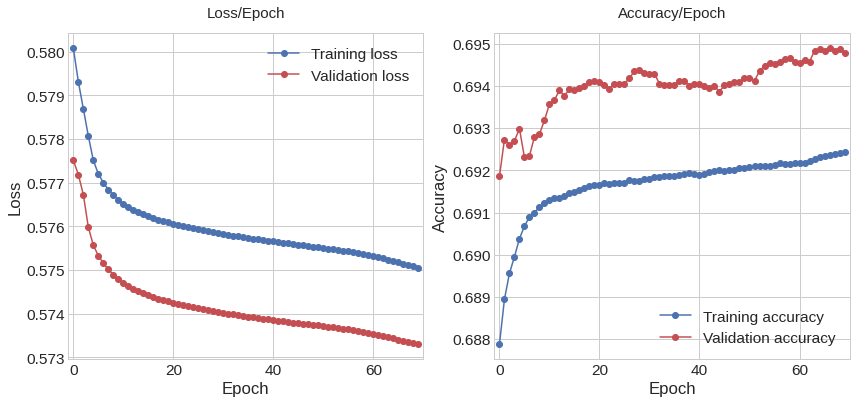

In [ ]:
plot_loss_accuracy(train_losses, train_accuracies, val_losses, val_accuracies, n_epochs)

**ROC curve**

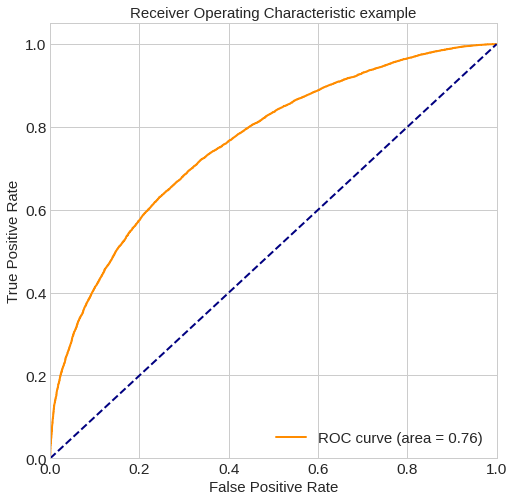

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, classification_report

# Get predictions of our best model.
y_score = nn_model.forward(glove_testX.float())

# Convert tensors to numpy arrays after we pass them to cpu.
y_score = y_score.cpu().detach().numpy()
y = testY.cpu().detach().numpy()

# Label binarization and store num of classes.
y_test = label_binarize(y, classes=[0, 1])
n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_score[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8,8))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=15)
plt.ylabel('True Positive Rate',fontsize=15)
plt.title('Receiver Operating Characteristic example', fontsize=15)
plt.legend(loc="lower right",fontsize=15)
plt.show()

**Confusion Matrix**

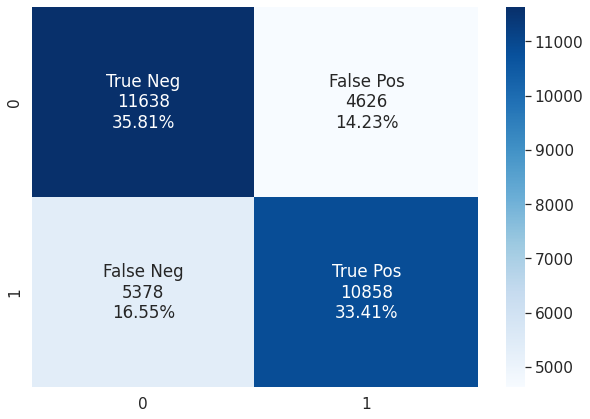

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn

df_cf_matrix = pd.DataFrame(confusion_matrix(testY,y_score.round()))
plt.figure(figsize=(10,7))
sn.set(font_scale=1.4)

group_labels = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in df_cf_matrix.values.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in df_cf_matrix.values.flatten()/np.sum(df_cf_matrix.values.flatten())]

box_labels = [f"{v1}\n{v2}\n{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
box_labels = np.asarray(box_labels).reshape(df_cf_matrix.shape[0],df_cf_matrix.shape[1])

sn.heatmap(df_cf_matrix, annot=box_labels, fmt='', cmap='Blues')

## **Summary** (some numbers) 📊

I have built a Feed-Forward Neural Network model which uses the GloVe pre-trained word embeddings for vectorizing the data (i.e., convert the words into numbers). 

My model got accuracy of ***70%*** and was having the following properties:

- Batch-size = $2^{15}$ = 32768
- Number of epochs = 70
- 3 hidden layers of size 1024, 512, and 256 respectively
- ReLU activation function for each layer
- Sigmoid function at the output

*I use the **early stopping** technique to stop at the epoch 70 because after that the model progresses very slowly and stays at the same accuracy of 70%. I have tried using 500 epochs but the model got again 70% accuracy.*